# SR Example

First be sure the notebook is running with GPU.

Runtime -> Change Runtime Type -> GPU

In [ ]:

# Colab only
# download and install Pytorch
# !pip install torch torchvision

In [ ]:
# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

In [ ]:
import torch
import torchvision
# mount the google drive
from google.colab import drive

from skimage.measure import block_reduce

drive.mount('/content/drive')
# path to the image on the drive
# image_filename = "/content/drive/My Drive/DL_denoising/DIV2K_valid_HR/0801.png"

#imagenet_data = torchvision.datasets.ImageNet('/My Drive/DL_denoising/DIV2K_valid_HR',train=False,transform=transform_ImageNet,download=True)


nb_images = 64 # 64


transformation_image = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(256), #128
    torchvision.transforms.Grayscale(3),
    torchvision.transforms.ToTensor()
])

notre_dataset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/DL_denoising/test_image',
                                           transform=transformation_image)

trainloader = torch.utils.data.DataLoader(notre_dataset,
                                          batch_size=nb_images, # 64 images prises 
                                          shuffle=True,
                                          num_workers=2)#args.nThreads



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


torch.Size([64, 3, 256, 256])


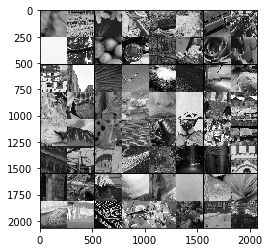

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample = next(iter(trainloader))[0]
show(torchvision.utils.make_grid(sample))
print(sample.shape)

In [ ]:
sample = next(iter(trainloader))[0]
print(sample.shape)

torch.Size([64, 3, 256, 256])


In [ ]:
sample.dtype

torch.float32

In [ ]:
print(sample[0].shape) # image n°1

torch.Size([3, 256, 256])


In [ ]:
print(sample[0][1]) # canal R de l'image n°1

tensor([[0.7333, 0.7098, 0.7255,  ..., 0.6510, 0.6549, 0.6392],
        [0.7255, 0.7255, 0.7255,  ..., 0.6588, 0.6588, 0.6039],
        [0.7922, 0.7647, 0.7333,  ..., 0.6549, 0.6588, 0.6039],
        ...,
        [0.0706, 0.1059, 0.4510,  ..., 0.4824, 0.4824, 0.4863],
        [0.0784, 0.0980, 0.4392,  ..., 0.4863, 0.4824, 0.4745],
        [0.0745, 0.1020, 0.4510,  ..., 0.4745, 0.4941, 0.4902]])


In [ ]:
sample_sous_ech = torch.Tensor(block_reduce(sample, block_size=(1,1,2,2), func=np.mean))
print(sample_sous_ech.shape)

torch.Size([64, 3, 128, 128])


In [ ]:
trans = torchvision.transforms.ToPILImage()

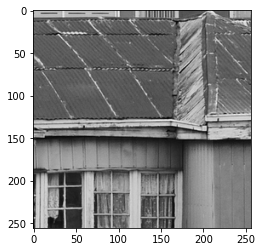

In [ ]:
plt.imshow(trans(sample[0]))

# load the image, convert it as an array of float, and divide to have [0,1] values

im = np.array(Image.open(image_filename), dtype=float)/255


im=im[1:257,1:257,:] # si im.shape est dimension 3
im.shape

**voilà comment sous échantilloné un Tensor**

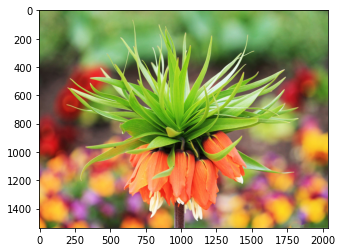

In [ ]:
image_filename = "/content/drive/My Drive/DL_denoising/test_image/DIV2K_valid_HR/0803.png"
img = np.array(Image.open(image_filename), dtype=np.float32)/255
plt.imshow(img)

In [ ]:
img.shape

(1536, 2040, 3)

In [ ]:
img.dtype

dtype('float32')

In [ ]:
type(img)

numpy.ndarray

In [ ]:
img_tensor = torch.Tensor(img)

In [ ]:
type(img_tensor)

torch.Tensor

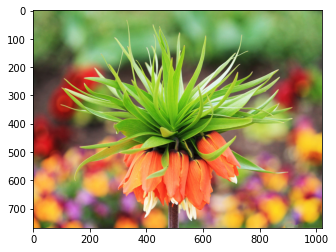

In [ ]:
from skimage.measure import block_reduce

image_sous_ech = torch.Tensor(block_reduce(img_tensor, block_size=(2,2,1), func=np.mean))
plt.imshow(image_sous_ech)

In [ ]:
image_sous_ech.shape

torch.Size([768, 1020, 3])

In [ ]:
type(image_sous_ech)

torch.Tensor

**fin sous ech Tensor**

In [ ]:
im = np.array(Image.open(image_filename), dtype=float)/255

# # im=im[1:257,1:257,:] # si im.shape est supérieur à (256,256,3) 
# im.shape
# # Setting the points for cropped image 
# left = 0
# top = 0
# right = 512
# bottom = 512
  
# # Cropped image of above dimension 
# # (It will not change orginal image) 

# # Il faut improter l'image HR sans NP puis cropper et transformer en np
# image = Image.open(image_filename)
# im1_pil = image.crop((left, top, right, bottom))
# im1 = np.array(image.crop((left, top, right, bottom)))
# plt.imshow(im1)
# print(im1.shape)
# image = Image.open(image_filename)
# facteur = 2

# new_image_pil = im1_pil.resize((256,256))

# # shape_compression = ( 256,256,3) #(int(im1.shape[1]/2), int(im1.shape[0]/2)  )


# # new_image = image.resize(256,256)  #  im1.resize( shape_compression )
# # new_image.save('image_400.jpg')
# print(im1_pil.size) 
# print(new_image_pil.size) 

# plt.imshow(new_image_pil)
# # display th eoriginal images
# plt.imshow(image)

In [ ]:
# convert to torch
#image = torch.from_numpy(im.transpose(2,0,1)).float().unsqueeze(0)
 # create a subsample image (the input of our network)
#print(inputs.size(), image.size())

## Neural network creation

The neural network is a Python class, it must inherit from the ```torch.nn.Module``` class of Pytorch.

It is composed of two main methods:
* ```__init__```, the contructor which define the layers to be used. The layers contain the paramters to be optimized
* ```forward```,  the method that define the links between the layers

As an example, we create a network based on UNet, a semantic segmentation network.
This network has an encoder / decoder strcuture with skip connection.

To do Super Resolution, we simply use add a last block with one dimension augmentation (```upconv0```).

In [ ]:
# create the neural network with Pytorch
class Unet(nn.Module):
  """Unet segmentation network."""

  def __init__(self, in_channels, out_channels):
    """Init Unet fields."""
    super(Unet, self).__init__()

    self.in_channels = in_channels

    self.conv11 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.bn11 = nn.BatchNorm2d(64)
    self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.bn12 = nn.BatchNorm2d(64)

    self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn21 = nn.BatchNorm2d(128)
    self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.bn22 = nn.BatchNorm2d(128)

    self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn31 = nn.BatchNorm2d(256)
    self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn32 = nn.BatchNorm2d(256)
    self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn33 = nn.BatchNorm2d(256)

    self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn41 = nn.BatchNorm2d(512)
    self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn42 = nn.BatchNorm2d(512)
    self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn43 = nn.BatchNorm2d(512)

    self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn51 = nn.BatchNorm2d(512)
    self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn52 = nn.BatchNorm2d(512)
    self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn53 = nn.BatchNorm2d(512)

    self.upconv5 = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv53d = nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1)
    self.bn53d = nn.BatchNorm2d(512)
    self.conv52d = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1)
    self.bn52d = nn.BatchNorm2d(512)
    self.conv51d = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1)
    self.bn51d = nn.BatchNorm2d(512)

    self.upconv4 = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv43d = nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1)
    self.bn43d = nn.BatchNorm2d(512)
    self.conv42d = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1)
    self.bn42d = nn.BatchNorm2d(512)
    self.conv41d = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1)
    self.bn41d = nn.BatchNorm2d(256)

    self.upconv3 = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv33d = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1)
    self.bn33d = nn.BatchNorm2d(256)
    self.conv32d = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1)
    self.bn32d = nn.BatchNorm2d(256)
    self.conv31d = nn.ConvTranspose2d(256,  128, kernel_size=3, padding=1)
    self.bn31d = nn.BatchNorm2d(128)

    self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv22d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
    self.bn22d = nn.BatchNorm2d(128)
    self.conv21d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
    self.bn21d = nn.BatchNorm2d(64)

    self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv12d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
    self.bn12d = nn.BatchNorm2d(64)
    self.conv11d = nn.ConvTranspose2d(64, out_channels, kernel_size=3, padding=1)

    # This is the modification added to Unet, for SR
    self.upconv0 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1, stride=2, output_padding=1)
    

  def forward(self, x):
    """Forward method."""
    # Stage 1
    x11 = F.relu(self.bn11(self.conv11(x)))
    x12 = F.relu(self.bn12(self.conv12(x11)))
    x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

    # Stage 2
    x21 = F.relu(self.bn21(self.conv21(x1p)))
    x22 = F.relu(self.bn22(self.conv22(x21)))
    x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

    # Stage 3
    x31 = F.relu(self.bn31(self.conv31(x2p)))
    x32 = F.relu(self.bn32(self.conv32(x31)))
    x33 = F.relu(self.bn33(self.conv33(x32)))
    x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

    # Stage 4
    x41 = F.relu(self.bn41(self.conv41(x3p)))
    x42 = F.relu(self.bn42(self.conv42(x41)))
    x43 = F.relu(self.bn43(self.conv43(x42)))
    x4p = F.max_pool2d(x43, kernel_size=2, stride=2)

    # Stage 5
    x51 = F.relu(self.bn51(self.conv51(x4p)))
    x52 = F.relu(self.bn52(self.conv52(x51)))
    x53 = F.relu(self.bn53(self.conv53(x52)))
    x5p = F.max_pool2d(x53, kernel_size=2, stride=2)

    # Stage 5d
    x5d = torch.cat((self.upconv5(x5p), x53), 1)
    x53d = F.relu(self.bn53d(self.conv53d(x5d)))
    x52d = F.relu(self.bn52d(self.conv52d(x53d)))
    x51d = F.relu(self.bn51d(self.conv51d(x52d)))

    # Stage 4d
    x4d = torch.cat((self.upconv4(x51d), x43), 1)
    x43d = F.relu(self.bn43d(self.conv43d(x4d)))
    x42d = F.relu(self.bn42d(self.conv42d(x43d)))
    x41d = F.relu(self.bn41d(self.conv41d(x42d)))

    # Stage 3d
    x3d = torch.cat((self.upconv3(x41d), x33), 1)
    x33d = F.relu(self.bn33d(self.conv33d(x3d)))
    x32d = F.relu(self.bn32d(self.conv32d(x33d)))
    x31d = F.relu(self.bn31d(self.conv31d(x32d)))

    # Stage 2d
    x2d = torch.cat((self.upconv2(x31d), x22), 1)
    x22d = F.relu(self.bn22d(self.conv22d(x2d)))
    x21d = F.relu(self.bn21d(self.conv21d(x22d)))

    print(x21d.shape)

    # Stage 1d
    x1d = torch.cat((self.upconv1(x21d), x12), 1)
    x12d = F.relu(self.bn12d(self.conv12d(x1d)))
    x11d = self.conv11d(x12d)
    
    ### Modification to Unet for SR
    y = self.upconv0(x11d)
    
    print(y.shape)

    return y

In [ ]:
# actual network creation
net = Unet(3,3)
net.cuda() # go GPU

# sample = sample.cuda() # go gpu for the image data


Unet(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn32): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
# inputs = inputs.cuda()

In [ ]:
# net.summary()

## Optimization

There are two steps.
First we create the optimizer and then, we loop over the dataset (here, only one image) 1000 times and optimize the network weights.

In [ ]:
# create the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

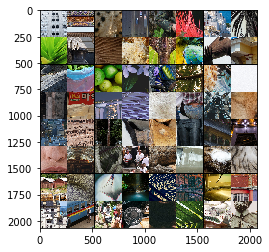

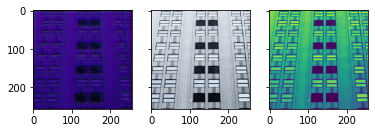

epoch n°21
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°22
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°23
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°24
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°25
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°26
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°27
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°28
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°29
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°30
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°31
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°32
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°33
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°34
torch.Size([64, 64, 64, 64])
torch.Size([64, 3, 256, 256])
epoch n°35
torch.Siz

In [ ]:
# Epoch loops (the number of times we see the training dataset)

nb_epoch = 100  # 1000
l_loss = []
for i in range(nb_epoch): # nb d'époque dans le réseau 
  
  print(f'epoch n°{i}')
  
  # for j in range(nb_images): # iterate over the dataset (here one single image, should be more)

  sample = next(iter(trainloader))[0]


  sample_sous_ech = torch.Tensor(block_reduce(sample, block_size=(1,1,2,2), func=np.mean))

  inputs = sample_sous_ech.clone()


  # inputs  = sample.Resize((64,64)) #((64,64))
  # forward pass, compute the output of the network
  outputs = net(inputs.cuda())
  
  # compute the error (here mean square error)
  loss = F.mse_loss(outputs.cpu(), sample)
  #print(f'la loss est {loss}')
  l_loss.append(loss.item())

  # reinitialize the gradients
  optimizer.zero_grad()
  
  # compute the gradients
  loss.backward()
  
  # update the weights
  optimizer.step()
  
  # display the results
  if i%20 == 0: #i%100 == 0
    show(torchvision.utils.make_grid(sample))
    trans = torchvision.transforms.ToPILImage()

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    clear_output(wait=True)
    outputs_np = outputs.cpu().detach().numpy()[0].transpose(1,2,0)
    outputs_np[outputs_np>1] = 1
    outputs_np[outputs_np<0] = 0
    ax1.imshow(outputs_np)
    
    im=trans(sample[0])
    ax2.imshow(im)
    ax3.imshow(((outputs_np-im)**2).sum(axis=2))
    plt.show()
    

In [ ]:
print(max(sample[0]))
# avoir un ecart type de 1 


RuntimeError: ignored

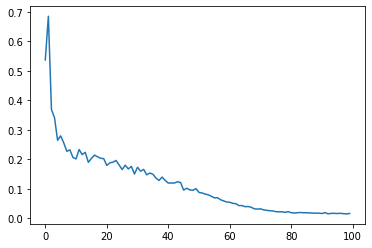

In [ ]:
plt.plot([j for j in range(nb_epoch)], l_loss)

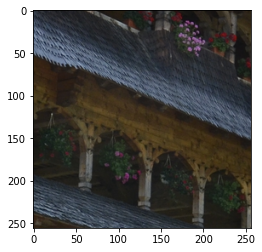

In [ ]:
im=trans(sample[0])
plt.imshow(im)

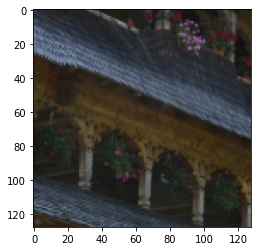

In [ ]:
im=trans(sample_sous_ech[0])
plt.imshow(im)

In [ ]:
outputs_np = outputs.cpu().detach()[0].transpose(1,2,0)

outputs_np[outputs_np>1] = 1
outputs_np[outputs_np<0] = 0
plt.imshow(outputs_np)
    


TypeError: ignored

In [ ]:
loss

tensor(0.0165, grad_fn=<MseLossBackward>)

In [ ]:
loss.shape


torch.Size([])

In [ ]:
loss.item() # c'est un float 

0.016473231837153435

In [ ]:
outputs_np.shape

(256, 256, 3)